START dir_name : 1


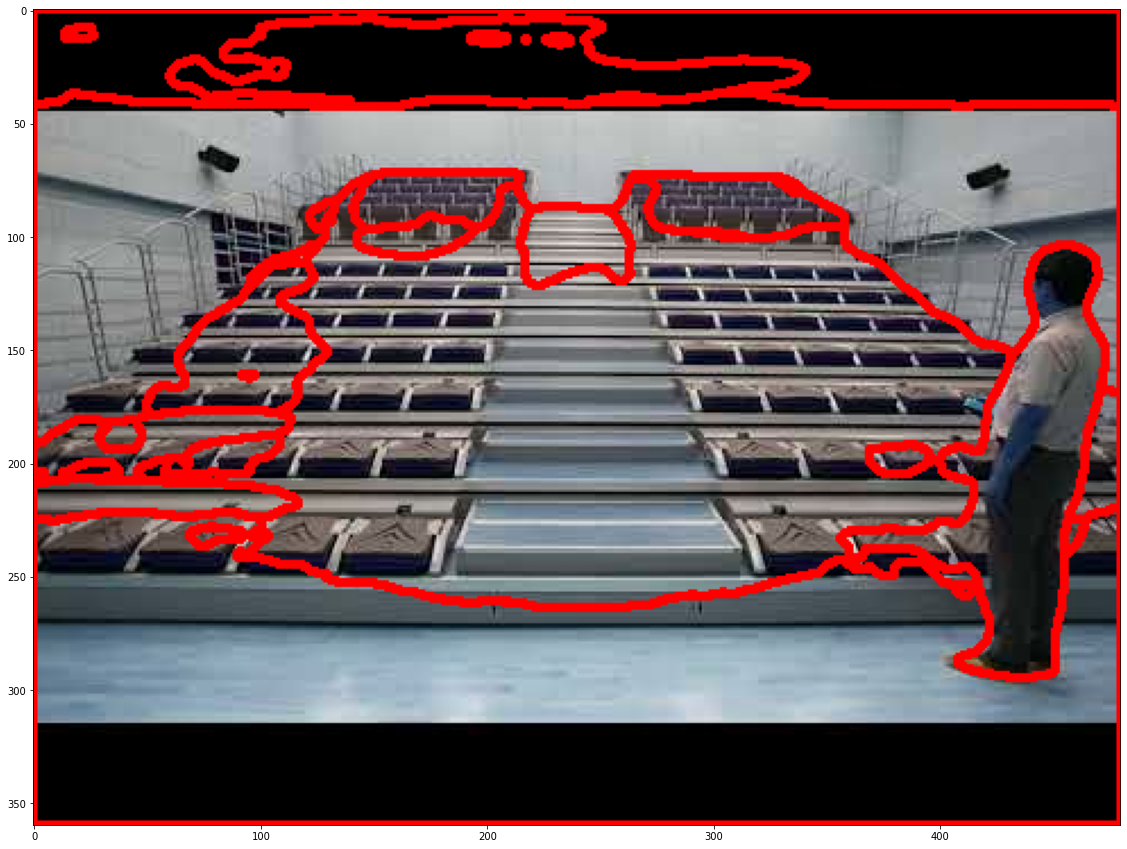

dir_name_jpg_count : 1 total_time : 18.664576768875122 average_time : 18.664576768875122
____________________________________________________________
ALL done.


In [1]:
# System libs
import os
import argparse
from distutils.version import LooseVersion
# Numerical libs
import numpy as np
import torch
import torch.nn as nn
from scipy.io import loadmat
import csv
# Our libs
from mit_semseg.dataset import TestDataset
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode, find_recursive, setup_logger
from mit_semseg.lib.nn import user_scattered_collate, async_copy_to
from mit_semseg.lib.utils import as_numpy
from PIL import Image
from tqdm import tqdm
from mit_semseg.config import cfg
import numpy as np
from imantics import Polygons, Mask
import copy
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
import json
import time 
import shutil

os.environ["CUDA_VISIBLE_DEVICES"]= "1,2,3,4"
colors = loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

label_name_dict = {15 : 'wall',
19 : 'building',
22 : 'void',
16 : 'floor',
20 : 'vegetation',
12 : 'road',
18 : 'obstacle',
21 : 'glasswall',
13 : 'sidewalk',
5 : 'pedestrian',
9 : 'other_static',
1 : 'vehicle',
8 : 'other_dynamic',
6 : 'bus',
7 : 'truck',
2 : 'motorcycle',
3 : 'bicycle',
11 : 'trafficlight'}

label_dict = {15: [1, 15, 19, 23, 25, 50, 63, 64, 101, 131, 135, 145], 
              19: [2, 26, 49, 52, 85], 
              22: [3, 6, 22, 27, 39, 61, 83, 86, 105, 110, 114, 129, 134], 
              16: [4, 29, 55], 20: [5, 17, 18, 30, 67, 69, 73, 95], 
              12: [7, 62], 
              18: [8, 11, 16, 24, 31, 32, 33, 34, 35, 36, 38, 40, 41, 43, 44, 45, 46, 48, 51, 54, 56, 57, 58, 60, 65, 66, 68, 70, 71, 72, 74, 75, 78, 79, 80, 82, 87, 88, 89, 94, 96, 97, 99, 100, 102, 106, 107, 108, 109, 112, 116, 118, 119, 121, 122, 123, 124, 130, 133, 136, 143, 146, 147], 
              21: [9, 28, 59, 148], 13: [12, 14, 47, 53, 92, 141], 
              5: [13], 9: [20, 37, 42, 76, 90, 93, 98, 111, 113, 115, 120, 125, 126, 132, 138, 139, 140, 142, 144, 149, 150], 
              1: [21, 103], 
              8: [77, 91, 104, 127], 
              6: [81], 
              7: [84], 
              2: [117], 
              3: [128], 
              11: [137]}


def visualize_result(data, pred, cfg):
    (img, info) = data

    # print predictions in descending order
    pred = np.int32(pred)
    pixs = pred.size
    uniques, counts = np.unique(pred, return_counts=True)
#     print(f'uniques : {uniques}, uniques.type ; {type(uniques)}, uniques.shape : {uniques.shape}')
#     uniques : [  0   1   2   4   6   9  11  12  16  17  41  87 104 112 125 127], uniques.type ; <class 'numpy.ndarray'>, uniques.shape : (16,)
#     print("Predictions in [{}]:".format(info))
    for idx in np.argsort(counts)[::-1]:
        name = names[uniques[idx] + 1]
        ratio = counts[idx] / pixs * 100
        if ratio > 0.1:
            pass
#             print("  {}: {:.2f}%".format(name, ratio))

    # colorize prediction
#     print(f'pred : {pred}, pred.type : {type(pred)}, pred.shape : {pred.shape}')
    
    
    polygon_total_dict = {}

    for category in uniques : 
        pred_copy = pred.copy()
        category = int(category) 
        label_category = int(category) + 1
        if label_category not in polygon_total_dict :
            polygon_total_dict[label_category] = []
        if category == 0 :
            pred_copy[pred_copy == 0] = 160
            pred_copy[pred_copy != 160] = 0
            pred_copy[pred_copy == 160] = 255

            plain_polygons = Mask(pred_copy).polygons()

            for polygon in plain_polygons.segmentation:

                if len(polygon) > 3:
                    polygon_total_dict[label_category].append(polygon)
        else : 
            pred_copy[pred_copy != category] = 0
            pred_copy[pred_copy == category] = 255

            plain_polygons = Mask(pred_copy).polygons()

            for polygon in plain_polygons.segmentation:
                if len(polygon) > 3:
                    polygon_total_dict[label_category].append(polygon)
    
#     pred_color = colorEncode(pred, colors).astype(np.uint8)

#     # aggregate images and save
#     im_vis = np.concatenate((img, pred_color), axis=1)

#     img_name = info.split('/')[-1]
#     Image.fromarray(im_vis).save(
#         os.path.join('/data/ij/edge/semantic-segmentation-pytorch/result_seg', img_name.replace('.jpg', '.png')))
    return polygon_total_dict


def test(segmentation_module, loader, gpu):
    segmentation_module.eval()

#     pbar = tqdm(total=len(loader))
    for batch_data in loader:
        # process data
        batch_data = batch_data[0]
        segSize = (batch_data['img_ori'].shape[0],
                   batch_data['img_ori'].shape[1])
        

        img_resized_list = batch_data['img_data']

        with torch.no_grad():
            scores = torch.zeros(1, cfg.DATASET.num_class, segSize[0], segSize[1])
            scores = async_copy_to(scores, gpu)

            for img in img_resized_list:
                feed_dict = batch_data.copy()
                feed_dict['img_data'] = img
                del feed_dict['img_ori']
                del feed_dict['info']
                feed_dict = async_copy_to(feed_dict, gpu)

                # forward pass
                pred_tmp = segmentation_module(feed_dict, segSize=segSize)
                # -- add this to avoid cuda out of memory
                pred_tmp = pred_tmp.cpu()
                scores = scores.cpu()
                # --
                scores = scores + pred_tmp / len(cfg.DATASET.imgSizes)

            _, pred = torch.max(scores, dim=1)
            pred = as_numpy(pred.squeeze(0).cpu())

        # visualization
        polygon_total_dict = visualize_result(
            (batch_data['img_ori'], batch_data['info']),
            pred,
            cfg
        )

#         pbar.update(1)
        return polygon_total_dict
## left,top,w,h
def getBboxFromPolygon(polygon):

    res = np.array(
        (
            (
                min(pts[0].min() for pts in polygon),
                min(pts[1].min() for pts in polygon),
            ),
            (
                max(pts[0].max() for pts in polygon),
                max(pts[1].max() for pts in polygon),
            ),
        )
    ) 
    return (res[0][0].item(),res[0][1].item(),res[1][0].item() - res[0][0].item(),res[1][1].item() - res[0][1].item())


def inference(cfg, gpu):
    torch.cuda.set_device(gpu)

    # Network Builders
    net_encoder = ModelBuilder.build_encoder(
        arch=cfg.MODEL.arch_encoder,
        fc_dim=cfg.MODEL.fc_dim,
        weights=cfg.MODEL.weights_encoder)
    net_decoder = ModelBuilder.build_decoder(
        arch=cfg.MODEL.arch_decoder,
        fc_dim=cfg.MODEL.fc_dim,
        num_class=cfg.DATASET.num_class,
        weights=cfg.MODEL.weights_decoder,
        use_softmax=True)

    crit = nn.NLLLoss(ignore_index=-1)

    segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)

    # Dataset and Loader
    dataset_test = TestDataset(
        cfg.list_test,
        cfg.DATASET)
    loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=cfg.TEST.batch_size,
        shuffle=False,
        collate_fn=user_scattered_collate,
        num_workers=5,
        drop_last=True)

    segmentation_module.cuda()

    # Main loop
    polygon_total_dict = test(segmentation_module, loader_test, gpu)
    return polygon_total_dict

#     print('Inference done!')



def load(cfg_path,opts) : 
    cfg.merge_from_file(cfg_path)
    cfg.merge_from_list(opts)
    # cfg.freeze()

    logger = setup_logger(distributed_rank=0)   # TODO
    #     logger.info("Loaded configuration file {}".format(cfg_path))
    #     logger.info("Running with config:\n{}".format(cfg))

    cfg.MODEL.arch_encoder = cfg.MODEL.arch_encoder.lower()
    cfg.MODEL.arch_decoder = cfg.MODEL.arch_decoder.lower()

    # absolute paths of model weights
    cfg.MODEL.weights_encoder = os.path.join(
        cfg.DIR, 'encoder_' + cfg.TEST.checkpoint)
    cfg.MODEL.weights_decoder = os.path.join(
        cfg.DIR, 'decoder_' + cfg.TEST.checkpoint)

    assert os.path.exists(cfg.MODEL.weights_encoder) and \
        os.path.exists(cfg.MODEL.weights_decoder), "checkpoint does not exitst!"


def make_json(img_path,polygon_total_dict,filename,save_path):
    image = cv2.imread(img_path)
    image_ori = cv2.imread(img_path)
    json_data = {"image_name" : f"{filename}.jpg"}
    seg_list = []

    for p_key in polygon_total_dict.keys():
        for key in label_dict.keys():
            l_list = label_dict[key]
            if p_key in l_list : 
                real_cate_number = key

        polygon_list = polygon_total_dict[p_key]

        for polygon in polygon_list : 
            points = np.array(polygon)
            points = points.reshape(int(len(polygon)/2),2)
            color_np = np.asarray(np.random.choice(range(256), size=3), dtype=np.uint8)
            color_fill = (color_np[0].item(),color_np[1].item(),color_np[2].item())
            
            isClosed = True
            color = (255, 0, 0)
            thickness = 2
            line_image = cv2.polylines(image, [points], isClosed, color, thickness)


#             image = cv2.fillPoly(image, pts=[points], color=color_fill)
            xywh = getBboxFromPolygon(points)
            box = {"left":xywh[0],"top":xywh[1],"width":xywh[2],"height":xywh[3]}
            ppoints = []
            for point in points:
                ppoints.append({"x":point[0].item(),"y":point[1].item()}) 
            seg_list.append({"box":box,"points":ppoints,"label_number":real_cate_number,"label_name":label_name_dict[real_cate_number]})
            
    save_json_file_path = save_path + '/'  + filename + '.json'
    json_data["seg"] = seg_list
#     with open(save_json_file_path, 'w', encoding='utf-8') as file:
#         json.dump(json_data, file, indent="\t")
#     print(f'SAVE COMPLETE {save_json_file_path}')
#     print(f'____________________________________________________________')
    
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(15)
    plt.imshow(line_image)
    plt.show() 

#     f = plt.figure()
#     f.set_figwidth(20)
#     f.set_figheight(15)
#     plt.imshow(image)
#     plt.show()

def main(filename,full_name,save_path,gpu):
    
    # generate testing image list
    imgs = full_name

    if os.path.isdir(imgs):
        imgs = find_recursive(imgs)
    else:
        imgs = [imgs]
    assert len(imgs), "imgs should be a path to image (.jpg) or directory."
    cfg.list_test = [{'fpath_img': x} for x in imgs]

    if not os.path.isdir(cfg.TEST.result):
        os.makedirs(cfg.TEST.result)

    polygon_total_dict = inference(cfg, gpu)

    make_json(full_name,polygon_total_dict,filename,save_path)
    
    

opts = []
gpu = 1
cfg_path = '/data/ij/edge/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml'
# original_jpg_path = '/data/ij/insadong'
original_jpg_path = '/data/ij/edge/semantic-segmentation-pytorch/seat'
dir_list = [f for f in os.listdir(original_jpg_path) if not f.startswith('.')] 
load(cfg_path,opts)

for dir_name in dir_list : 
    print(f'START dir_name : {dir_name}')
    
    full_dir_path = f'{original_jpg_path}/{dir_name}'
    fileEx = r'.jpeg'
    jpg_list = [file for file in os.listdir(full_dir_path) if file.endswith(fileEx)]

    if len(jpg_list) == 0 :
        print(f'Nothing in there : {full_dir_path}')
        continue
    
    
    save_path = f'/data/ij/insadong_meta/{dir_name}'
#     if not os.path.exists(save_path) :
#         os.mkdir(save_path)
#     else : 
#         shutil.rmtree(save_path)
#         os.mkdir(save_path)


    start = time.time()
    for file in jpg_list : 
        full_name = full_dir_path + '/' + file
        file_name = file[:-4]
        main(file_name,full_name,save_path,gpu)
    end = time.time()
    
    total_time = end - start

    average_time = total_time/int(len(jpg_list))
    
    print(f'dir_name_jpg_count : {len(jpg_list)} total_time : {total_time} average_time : {average_time}')
    print(f'____________________________________________________________')
print('ALL done.')

In [2]:
# ! pip3 install imantics

In [3]:
# import numpy as np 
# a = np.array([1,2])
# for i in a :
#     print(type(int(i)))